In [62]:
import pandas as pd
import seaborn as sns

import pyspark.sql
from pyspark.sql import SparkSession, functions

from pyspark.ml.feature import StopWordsRemover, Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

pd.options.display.max_columns = None
pd.options.display.max_rows = 50
sns.set(color_codes=True)

In [45]:
spark = SparkSession.builder.appName('Tweets').getOrCreate()

In [46]:
schema = "polarity FLOAT, id LONG, date_time STRING, query STRING, user STRING, text STRING"
timestampFormat = 'EEE MMM dd HH:mm:ss zzz yyyy'

train = spark.read.schema(schema).csv(
    path='../../data/tweet/training.1600000.processed.noemoticon.csv',
    header=False,
    timestampFormat=timestampFormat
)

test = spark.read.schema(schema).csv(
    path='../../data/tweet/testdata.manual.2009.06.14.csv',
    header=False,
    timestampFormat=timestampFormat
)

In [47]:
train.show()

+--------+----------+--------------------+--------+---------------+--------------------+
|polarity|        id|           date_time|   query|           user|                text|
+--------+----------+--------------------+--------+---------------+--------------------+
|     0.0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0.0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0.0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0.0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0.0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0.0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0.0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0.0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     0.0|1467811795|

In [48]:
test.show()

+--------+---+--------------------+-------+--------------+--------------------+
|polarity| id|           date_time|  query|          user|                text|
+--------+---+--------------------+-------+--------------+--------------------+
|     4.0|  3|Mon May 11 03:17:...|kindle2|        tpryan|@stellargirl I lo...|
|     4.0|  4|Mon May 11 03:18:...|kindle2|        vcu451|Reading my kindle...|
|     4.0|  5|Mon May 11 03:18:...|kindle2|        chadfu|Ok, first assesme...|
|     4.0|  6|Mon May 11 03:19:...|kindle2|         SIX15|@kenburbary You'l...|
|     4.0|  7|Mon May 11 03:21:...|kindle2|      yamarama|@mikefish  Fair e...|
|     4.0|  8|Mon May 11 03:22:...|kindle2|  GeorgeVHulme|@richardebaker no...|
|     0.0|  9|Mon May 11 03:22:...|    aig|       Seth937|Fuck this economy...|
|     4.0| 10|Mon May 11 03:26:...| jquery|     dcostalis|Jquery is my new ...|
|     4.0| 11|Mon May 11 03:27:...|twitter|       PJ_King|       Loves twitter|
|     4.0| 12|Mon May 11 03:29:...|  oba

/Users/chipanatica/opt/anaconda3/envs/study/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

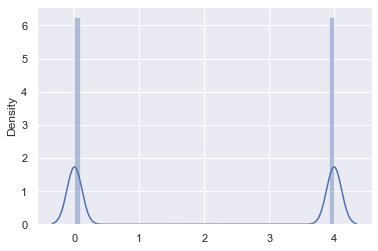

In [49]:
sns.distplot(train.select('polarity').toPandas())

/Users/chipanatica/opt/anaconda3/envs/study/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

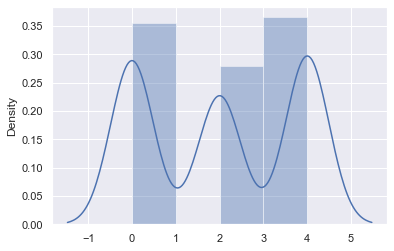

In [50]:
sns.distplot(test.select('polarity').toPandas())

In [51]:
train.groupby('polarity').count().toPandas()

,polarity,count
0,4.0,800000
1,0.0,800000


In [52]:
test.groupby('polarity').count().toPandas()

,polarity,count
0,2.0,139
1,4.0,182
2,0.0,177


In [53]:
train = train.drop('id').drop('user')
test = test.drop('id').drop('user')

test = test.filter(test.polarity.isin([0.0, 4.0]))

In [54]:
test.groupby('polarity').count().toPandas()

,polarity,count
0,4.0,182
1,0.0,177


In [55]:
user_regex = r"(@\w{1,15})"
hashtag_regex = r"(#\w{1,})"
url_regex = r"((https?|ftp|file):\/{2,3})+([-\w+&@#/%=~|$?!:,.]*)|(www.)+([-\w+&@#/%=~|$?!:,.]*)"
email_regex = r"[\w.-]+@[\w.-]+\.[a-zA-Z]{1,}"

In [56]:
def clean_text(df: pyspark.sql.dataframe.DataFrame):
    df = df.withColumn('original_text', functions.col('text'))\
        .withColumn('text', functions.regexp_replace(functions.col('text'), user_regex, ' '))\
        .withColumn('text', functions.regexp_replace(functions.col('text'), url_regex, ' '))\
        .withColumn('text', functions.regexp_replace(functions.col('text'), email_regex, ' '))\
        .withColumn('text', functions.regexp_replace(functions.col('text'), hashtag_regex, ' '))\
        .withColumn('text', functions.regexp_replace(functions.col('text'), "[^a-zA-Z']", ' '))\
        .withColumn('text', functions.regexp_replace(functions.col('text'), " +", ' '))\
        .withColumn('text', functions.trim(functions.col('text')))\
        .filter("text != '' ")

    return df

In [57]:
train = clean_text(train)
test = clean_text(test)

In [58]:
train.show()

+--------+--------------------+--------+--------------------+--------------------+
|polarity|           date_time|   query|                text|       original_text|
+--------+--------------------+--------+--------------------+--------------------+
|     0.0|Mon Apr 06 22:19:...|NO_QUERY|A that's a bummer...|@switchfoot http:...|
|     0.0|Mon Apr 06 22:19:...|NO_QUERY|is upset that he ...|is upset that he ...|
|     0.0|Mon Apr 06 22:19:...|NO_QUERY|I dived many time...|@Kenichan I dived...|
|     0.0|Mon Apr 06 22:19:...|NO_QUERY|my whole body fee...|my whole body fee...|
|     0.0|Mon Apr 06 22:19:...|NO_QUERY|no it's not behav...|@nationwideclass ...|
|     0.0|Mon Apr 06 22:20:...|NO_QUERY|  not the whole crew|@Kwesidei not the...|
|     0.0|Mon Apr 06 22:20:...|NO_QUERY|          Need a hug|         Need a hug |
|     0.0|Mon Apr 06 22:20:...|NO_QUERY|hey long time no ...|@LOLTrish hey  lo...|
|     0.0|Mon Apr 06 22:20:...|NO_QUERY|nope they didn't ...|@Tatiana_K nope t...|
|   

In [65]:
train = train.select('text', 'polarity')
test = test.select('text', 'polarity')

21/12/23 19:59:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [66]:
train.repartition(20).write.partitionBy('polarity').parquet('../../data/tweet/tweetsSkinClean', mode='overwrite')

21/12/23 19:59:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/12/23 19:59:19 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/12/23 19:59:48 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 96,54% for 7 writers
21/12/23 19:59:48 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 84,47% for 8 writers
21/12/23 19:59:48 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 96,54% for 7 writers
21/12/23 19:59:48 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 96,54% for 7 writers
21/12/23 19:59:48 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 84,47% for 8 writers
21/12/23 19:59:48 WARN MemoryManager: Total allocation exceeds 

In [67]:
train_data, valid_data = train.randomSplit([0.7, 0.3], seed=2021)

In [68]:
tokenizer = Tokenizer(inputCol='text', outputCol='textTokenizer')
stopWordRemover = StopWordsRemover(inputCol='textTokenizer',
                                   outputCol='textStopWordRemover',
                                   stopWords=StopWordsRemover.loadDefaultStopWords('english')
                                   )

hashingTF = HashingTF(inputCol='textStopWordRemover', outputCol='textTF')
idf = IDF(inputCol='textTF', outputCol='features', minDocFreq=10)

lr = LogisticRegression(labelCol='polarity')

pipeline = Pipeline(stages=[
    tokenizer,
    stopWordRemover,
    hashingTF,
    idf,
    lr
])

21/12/23 19:59:50 WARN StopWordsRemover: Default locale set was [es_419]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [69]:
model = pipeline.fit(train)

21/12/23 20:00:26 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/12/23 20:01:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/12/23 20:01:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/12/23 20:01:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/12/23 20:01:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/12/23 20:01:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/12/23 20:01:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/12/23 20:01:47 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/12/23 20:01:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


KeyboardInterrupt: 

In [ ]:
model.transform(valid_data).show()
model.transform(test).show()